In [1]:
#Math Part
import numpy as np
import pandas as pd
import time

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

<module 'gsvm' from 'c:\\Users\\londh\\qc\\Automatic_design_of_quantum_feature_maps_Genetic_Auto-Generation-main\\Qkrishi---QSVM\\gsvm.py'>

In [48]:
output="bank_testdata.csv"
df = pd.read_csv('bank_cleaned.csv')

bank_data = df.sample(n = 4000)

y = bank_data['y'].values
X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','duration','campaign','pdays','previous','poutcome']].values
start = time.time()

pop, pareto, logbook = gsvm.gsvm(nqubits=3, depth=3, nparameters=2,
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=20,lambda_=10, ngen=50,mutpb=0.5,cxpb=0.5)
print(f'Simulation finished after {time.time()-start} seconds')


print(f'\nGenetic-algorithm output ({output})')
print('---------------------------------------------')
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


String: 110000110100110110100010001000100111001000000
 -> accuracy = 0.58375, gates = 8.0,recall = 0.5753086419753086
String: 011001110110011011110000100001011110010110110
 -> accuracy = 0.595, gates = 9.0,recall = 0.7654320987654321
String: 001100011101101101011000101101011010100010110
 -> accuracy = 0.635, gates = 8.0,recall = 0.7012345679012346
String: 101001101001011011101000000101111001100001110
 -> accuracy = 0.62875, gates = 6.0,recall = 0.6790123456790124
String: 001100111010000010000111101100100011001100110
 -> accuracy = 0.60375, gates = 10.0,recall = 0.6222222222222222
String: 011011100111100101010110000000111000110110010
 -> accuracy = 0.61375, gates = 7.0,recall = 0.6444444444444445
String: 011001111001101100101111100100100110101000110
 -> accuracy = 0.6275, gates = 10.0,recall = 0.745679012345679
String: 010100001100001000101001000000111111000101011
 -> accuracy = 0.58375, gates = 7.0,recall = 0.5580246913580247
String: 010011100100001010111110101110001001100011111
 -> ac

In [49]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,69,110111100010010010010101110001011100100001011,1.433952,0.65875
1,70,110110100010010010010101110001011100100001001,1.433952,0.65875
2,71,110010100010010010010101110001011100101011001,1.433952,0.65875
3,72,110111100010010011011011010110011101101010101,1.433952,0.65875
4,73,110111100010010010010101110001011100101011001,1.433952,0.65875
...,...,...,...,...
70,1,110001100011010010001100111001010011011010111,0.000000,0.50625
71,2,110100100011010010111100111001010011011010111,0.000000,0.50625
72,3,110001100011010010001101011001110001011010111,0.000000,0.50625
73,4,110100100011010010111100111001010011010110111,0.000000,0.50625


['11011', '11000', '10010', '01001', '01011', '10001', '01110', '01000', '01011']
3.0


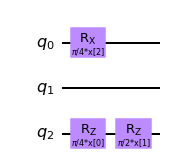

In [50]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor(nqubits=3, nparameters=3)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [5]:
def featuremap_performance(pop:str,nqubits:int,nparameters:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''

    df = pd.read_csv('bank_cleaned.csv')
    bank_data = df.sample(n = 20000)

    y = bank_data['y'].values
    X = bank_data[['age','job','marital','education','default','balance',
                'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


    fitness_obj = fitness.Fitness(nqubits,nparameters,X,y,debug=True)

    training_features, training_labels, test_features, test_labels = fitness.Dataset(X,y)

    model = qsvm.QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

    y_pred = model.predict(test_features)

    cm = confusion_matrix(test_labels, y_pred)

    #cm_display = ConfusionMatrixDisplay(cm).plot()
    ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
    plt.show()
    recall = recall_score(test_labels, y_pred)
    acc  = accuracy_score(test_labels, y_pred)

    print(f'String = {pop},\n accuracy = {acc}, recall = {recall}')
    
    return None

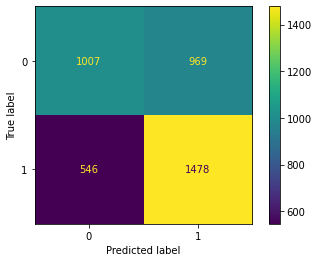

String = 110111100010010010010101110001011100100001011,
 accuracy = 0.62125, recall = 0.7302371541501976


In [51]:
featuremap_performance(iot_salidas.circ[0],3,3)

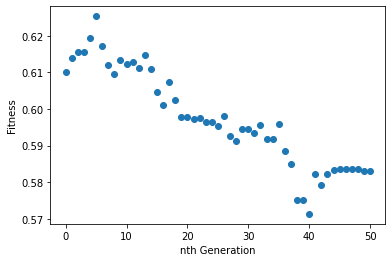

In [55]:
gen = logbook.select("gen")
avgs = []

for i in gen:
    avgs.append(logbook[i]['media'])

#plt.ylim([0.4,.6])
plt.scatter(gen,avgs)
plt.xlabel('nth Generation')
plt.ylabel('Fitness')

plt.show()